<a href="https://colab.research.google.com/github/LeejwUniverse/basic_transformer/blob/main/basic_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import json

import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [38]:
config = Config({
    "n_enc_vocab": 1000,
    "n_dec_vocab": 1000,
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 2,
    "d_hidn": 128,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 32,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})
print(config)

{'n_enc_vocab': 1000, 'n_dec_vocab': 1000, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 2, 'd_hidn': 128, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 32, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12}


**1. Positional Encoding**

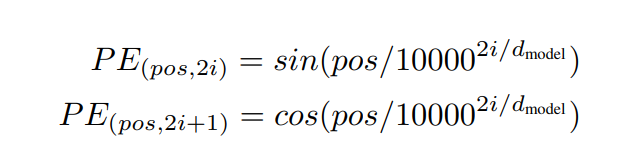

In [16]:
"""sinusoid positional encoding"""
def sinusoid_positional_encoding(n_seq, d_model):
  sinusoid = np.array([[pos / np.power(10000, 2 * (index // 2) / d_model) for index in range(d_model)] for pos in range(n_seq)])
  ## 64 시퀀스, 128 model_hidden size. (index//2)인 이유는 0,1이 index로 들어가면 0/2 = 0 , 1/2 = 0.5 몫만 취하므로 둘다 0임 하지만 sin,cos번갈아가기 때문에
  ## 각 sin, cos함수에서 순서대로 짝수들이 0: 0, 1: 2, 2: 4 | 홀수들이 0: 1, 1: 3, 2: 5와 같이 계산된다.(앞에 숫자들이 함수의 순서, 뒤에 숫자들이 실제 sinusoid table index)
  
  sinusoid[:, 0::2] = np.sin(sinusoid[:, 0::2]) ## 짝수 column 계산 0,2,4,6,8 
  sinusoid[:, 1::2] = np.cos(sinusoid[:, 1::2]) ## 홀수 column계산 1,3,5,7,9
  
  return sinusoid

In [17]:
print(sinusoid_positional_encoding(10,128).shape)
# 10: 아이템 시퀀스 갯수 item 0 - item 1 ... - item 10
# 128: 각 아이템의 위치를 128 vector로 표현한다.

(10, 128)


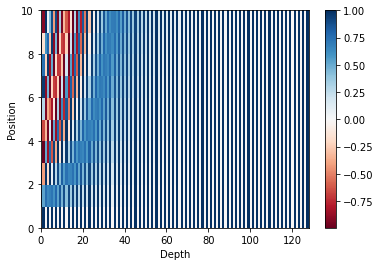

In [18]:
n_seq = 10
d_model = 128
pos_encod = sinusoid_positional_encoding(n_seq, d_model)

plt.pcolormesh(pos_encod, cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [19]:
def get_attention_padd_mask(seq_q, seq_k, i_pad):
  batch_size, len_q = seq_q.size()
  batch_size, len_k = seq_k.size()
  pad_attention_mask = seq_k.data.eq(i_pad).unsqueeze(1).expand(batch_size, len_q, len_k)
  
  return pad_attention_mask

In [20]:
def decoder_get_attention_padd_mask(seq):
  subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
  subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
  
  return subsequent_mask

In [21]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.sqrt_d_k = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        
        scores = torch.matmul(Q, K.transpose(-1, -2))
        scores = torch.mul(scores,self.sqrt_d_k)

        scores.masked_fill_(attn_mask, -1e9) ## masking 해주기.
        
        soft = nn.Softmax(dim=-1) ## softmax 선언

        attn_prob = soft(scores) ## softmax 값 구하기.
        attn_prob = self.dropout(attn_prob) ## dropout 0.2 걸어주기.
        
        attn_result = torch.matmul(attn_prob, V) ## matrix multiplication softmax * V
        
        return attn_result, attn_prob ## 

In [42]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        QW_Q = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        KW_K = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        VW_V = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        attn_result, attn_prob = self.scaled_dot_attn(QW_Q, KW_K, VW_V, attn_mask) ## masking 되고 쪼개진 q, k, v를 attention score 계산해줌.
        # (bs, n_head, n_q_seq, h_head * d_head)
        attn_result = attn_result.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(attn_result)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        
        return output, attn_prob

In [23]:
class PoswiseFeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config
    self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
    self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, inputs):
    output = F.relu(self.conv1(inputs.transpose(1,2)))
    output = self.conv2(output).transpose(1,2)
    output = self.dropout(output)

    return output

In [24]:
class Encoder_module(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.self_attn = MultiHeadAttention(self.config)
    self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    self.pos_ff = PoswiseFeedForward(self.config)
    self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)

  def forward(self, inputs, attn_mask):
    print(inputs.size())

    attn_result, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
    mid_outputs = self.layer_norm1(inputs + attn_result) ## residual + attention_output 결과 먼저 + 연산 후에 layerNorm에 넣음.

    pos_ff_outputs = self.pos_ff(mid_outputs)
    enc_layer_outputs = self.layer_norm2(pos_ff_outputs + mid_outputs)

    return enc_layer_outputs, attn_prob

In [34]:
class Encoder(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.config = config

    self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
    sinusoid_table = torch.FloatTensor(sinusoid_positional_encoding(self.config.n_enc_seq + 1, self.config.d_hidn))
    self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)
    self.layers = nn.ModuleList([Encoder_module(self.config)])

  def forward(self, inputs):
    print(inputs.size())
    print(inputs.size(0), inputs.size(1)) # [batch, longest len].
    positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1 # 1부터 max까지 index 값 저장됨.
    print(positions)
    pos_mask = inputs.eq(self.config.i_pad)
    print("pos_mask: ", pos_mask)
    print(pos_mask.size(), positions.size())
    positions.masked_fill_(pos_mask, 0) # pos_mask 부분을 0으로 채워줌.
    print("positions: ", positions)

    enc_layer_outputs = self.enc_emb(inputs) + self.pos_emb(positions)
    print("enc: ", enc_layer_outputs.size())
    attn_mask = get_attention_padd_mask(inputs, inputs, self.config.i_pad)
    print("attention mask: ", attn_mask)
    print(attn_mask.size())
    attn_probs = []
    
    for layer in self.layers:
      enc_layer_outputs, attn_prob = layer(enc_layer_outputs, attn_mask)
      attn_probs.append(attn_prob)
    
    return enc_layer_outputs, attn_probs

In [26]:
class Decoder_module(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ff = PoswiseFeedForward(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        
        ffn_outputs = self.pos_ff(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

In [27]:
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(sinusoid_positional_encoding(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([Decoder_module(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
    
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        dec_attn_pad_mask = get_attention_padd_mask(dec_inputs, dec_inputs, self.config.i_pad) ## 기본적인 마스킹
      
        dec_attn_decoder_mask = decoder_get_attention_padd_mask(dec_inputs) ## 디코더를 위한 마스킹

        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0) ## ?? 이해 못함
        
        dec_enc_attn_mask = get_attention_padd_mask(dec_inputs, enc_inputs, self.config.i_pad) ## 인코더 아웃풋과 디코더 아웃풋들이 만나는 attention에 사용.

        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
       
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

In [39]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs) # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs) # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]

In [43]:
transformer = Transformer(config)

In [45]:
encoder_input = torch.randint(0,1, (2, 10)) # (batch_size, items)
decoder_input = torch.randint(0,1, (2, 10)) # (batch_size, items)
print(encoder_input)
dec_outputs = transformer(encoder_input,decoder_input)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
torch.Size([2, 10])
2 10
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
pos_mask:  tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])
torch.Size([2, 10]) torch.Size([2, 10])
positions:  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
enc:  torch.Size([2, 10, 128])
attention mask:  tensor([[[True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True],
         [True, True, True, True, 